In [ ]:
import sys,os
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import files
  file=files.upload() # upload the savced kaggle.json
  !mkdir /root/.kaggle # on colab you are use root
  !mv kaggle.json  /root/.kaggle
  !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
  !pip install lightning pygments==2.6.1 >/dev/null 2>&1
  !pip install comet-ml >/dev/null 2>&1
  !unzip -q /content/gtzan-dataset-music-genre-classification.zip
  data_path="./Data/images_original"
elif os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None:
  !pip install lightning > /dev/null 2>&1
  !pip install comet-ml >/dev/null 2>&1
  data_path="/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original"
else:
  data_path="~/Downloads/archive/Data/images_original"


In [ ]:
import lightning as L
import comet_ml
from comet_ml import Experiment
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger,CometLogger
from lightning.pytorch.callbacks import ModelCheckpoint,Callback

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader,random_split
import matplotlib.pyplot as plt
import datetime
import copy
import torchmetrics
from tqdm import tqdm

In [ ]:
comet_ml.init(project_name="music-classification")
experiment=Experiment()
experiment.set_name("pytorch")
seed_everything(123, workers=True)
hyper_params = {"batch_size": 32, "num_epochs": 20, "learning_rate": 0.001,"momentum":0.9}
experiment.log_parameters(hyper_params)
num_workers=0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class CustomDataset(Dataset):
    def __init__(self,subset,transform=None):
        self.subset=subset
        self.transform=transform
    def __getitem__(self,idx):
        x,y=self.subset[idx]
        if self.transform:
            x=self.transform(x)
        return x,y
    def __len__(self):
        return len(self.subset)

In [ ]:
data_transforms = {
     'train':  transforms.Compose([ transforms.TrivialAugmentWide(),
                                   transforms.CenterCrop(224),transforms.ToTensor(),
                                   transforms.Normalize([0., 0., 0.], [1., 1., 1.])]),
  
    'val': transforms.Compose([transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0., 0., 0.], [1., 1., 1.])
    ]),
    
    'test': transforms.Compose([transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0., 0., 0.], [1., 1., 1.])
    ])
}

In [ ]:
dataset=torchvision.datasets.ImageFolder(data_path)
num_classes=len(dataset.classes)
datasets={}
datasets['train'],datasets['val'],datasets['test']=random_split(dataset,lengths=[0.7,0.2,0.1])
image_datasets = {x: CustomDataset(datasets[x],data_transforms[x])
                  for x in ['train', 'val','test']}
dataset_sizes={x:len(image_datasets[x]) for x in ['train','val','test']}
dataloaders={x:DataLoader(image_datasets[x], batch_size=hyper_params['batch_size'],
                                             shuffle=True if x=='train' else False, num_workers=num_workers)
                                             for x in ['train','val','test']}

In [ ]:
class ResNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.resnet=models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc=nn.Linear(self.resnet.fc.in_features,num_classes)
    def forward(self,x):
        return self.resnet(x)

In [ ]:
def test(model, criterion,loader):
    with torch.no_grad():
        model.eval()   
        running_loss = 0.0        
        test_acc=torchmetrics.Accuracy('multiclass',num_classes=num_classes).to(device)
        confmat=torchmetrics.ConfusionMatrix(task='multiclass',num_classes=num_classes).to(device)
        for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                confmat.update(preds,labels)
                batch_acc=test_acc(preds,labels.data)
            
        total_acc=test_acc.compute()
       
    return total_acc,confmat
def validate(model, criterion,loader):
    with torch.no_grad():
        model.eval()   
        running_loss = 0.0        
        val_acc=torchmetrics.Accuracy('multiclass',num_classes=num_classes).to(device)
        for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * hyper_params['batch_size']
                batch_acc=val_acc(preds,labels.data)
            
        epoch_loss = running_loss / (len(loader)*hyper_params['batch_size'])
        epoch_acc=val_acc.compute()
       
    return epoch_loss,epoch_acc

In [ ]:
def train_model(model, criterion, optimizer,scheduler=None, num_epochs=100):
    for epoch in range(hyper_params['num_epochs']):
        
        model.train()  
        running_loss=0.
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
      
        train_acc=torchmetrics.Accuracy('multiclass',num_classes=num_classes).to(device)
        loop=tqdm(dataloaders['train'])
        loop.set_description(f"Epoch [{epoch+1}/{hyper_params['num_epochs']}]")

        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            batch_acc=train_acc(preds,labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss =0.9*running_loss+0.1*loss.item() 
            if epoch>0:
                 loop.set_postfix(loss=running_loss,t_acc=epoch_acc.item(),val_acc=v_acc.item())
            else:
                 loop.set_postfix(loss=running_loss)
       

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc=train_acc.compute()        
        experiment.log_metric(epoch_loss,epoch)
        v_loss,v_acc=validate(model,criterion,dataloaders['val'])
        experiment.log_metrics({"train_loss":epoch_loss,"train_acc":epoch_acc},epoch=epoch)

        experiment.log_metrics({"val_loss":v_loss,"val_acc":v_acc},epoch=epoch)

        if  v_acc > best_acc:
                best_acc = v_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        train_acc.reset()
    ## training is done. Return the model with the best validation accuracy
    model.load_state_dict(best_model_wts)
    return model

In [ ]:

model=ResNet(num_classes=num_classes)
model=model.to(device)
optimizer=optim.SGD(model.parameters(),lr=hyper_params['learning_rate'],momentum=hyper_params['momentum'])
#optimizer=optim.Adam(model.parameters(),lr=0.0001)
criterion=nn.functional.cross_entropy

model=train_model(model=model,criterion=criterion,optimizer=optimizer,scheduler=None,num_epochs=hyper_params['num_epochs'])


In [ ]:
test_acc,confmat=test(model,criterion,dataloaders['test'])
print(test_acc.item())
experiment.log_metric("test_acc",test_acc.item())
experiment.end()

In [65]:
print(test_acc.item())

0.747474730014801


In [57]:
mat=confmat.compute().cpu().numpy()

<AxesSubplot: >

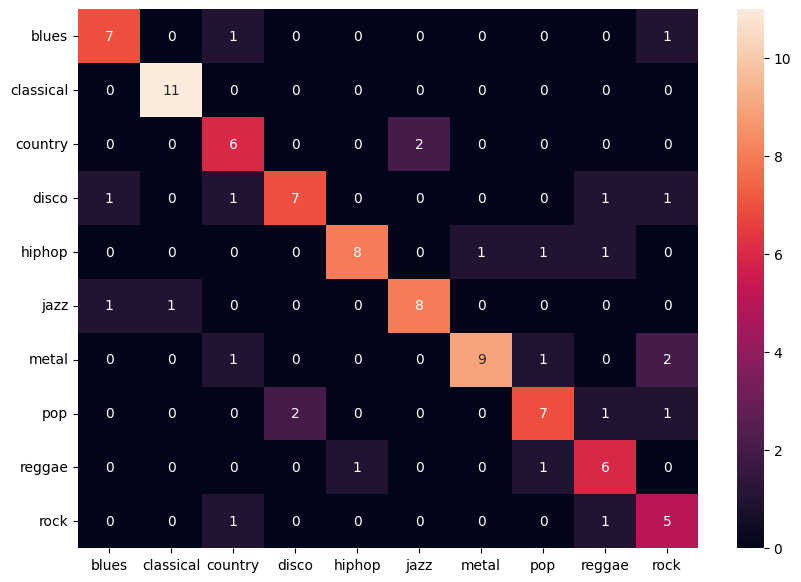

In [68]:
import matplotlib.pyplot as plt
import seaborn as sb
x=confmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset.classes,yticklabels=dataset.classes,annot=True,fmt=".0f")

In [67]:
np.sum(mat,axis=1)

array([ 9, 11,  8, 11, 11, 10, 13, 11,  8,  7])

In [61]:
classes=[]
for img,label in datasets['test']:
    classes.append(label)

In [62]:
import numpy as np
values,count=np.unique(classes,return_counts=True)

In [63]:
count

array([ 9, 11,  8, 11, 11, 10, 13, 11,  8,  7])